# Chapter: Statistics in AI Pipelines

This notebook accompanies the textbook chapter **Statistics in AI Pipelines**. It contains all Python code examples organized by section, with markdown explanations for each block.

> **Full repository:** [github.com/jalil-piran/probability-statistics-ai-code](https://github.com/jalil-piran/probability-statistics-ai-code/volume1/part02_statistics)

---

## Table of Contents
1. [Systematic EDA Workflow](#eda)
2. [Detecting Distribution Shift](#shift)
3. [Outlier Detection and Missing Data Handling](#quality)
4. [Feature Understanding and Engineering](#features)

---

## Setup: Install and Import Dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, IsolationForest
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

np.random.seed(42)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11
print("All imports successful.")

<a id='eda'></a>
---
## 1. Systematic EDA Workflow

### Section 2.3 — Exploratory Data Analysis for AI

Exploratory Data Analysis (EDA) follows a five-stage progression:

| Stage | Task |
|-------|------|
| 1 | Initial inspection: shape, types, missing values, duplicates |
| 2 | Univariate analysis: distributions, skewness, outliers |
| 3 | Bivariate analysis: correlations, pairwise relationships |
| 4 | Multivariate analysis: correlation matrices, PCA |
| 5 | Target–feature relationships: predictive power, class differences |

The synthetic dataset below deliberately includes common real-world issues:
- **Missing values** in `feature_1` (~5%)
- **Outliers** injected into `feature_2`
- **Multicollinearity**: `feature_5` ≈ `feature_1` + noise
- **Class imbalance**: target is 70% class 0, 30% class 1
- **Skewness**: `feature_2` follows an exponential distribution

In [3]:
import numpy as np
import pandas as pd
np.random.seed(42)
n_samples = 1000

data = pd.DataFrame({
    'feature_1': np.random.normal(50, 10, n_samples),
    'feature_2': np.random.exponential(2, n_samples),
    'feature_3': np.random.choice(['A', 'B', 'C'], n_samples, p=[0.5, 0.3, 0.2]),
    'feature_4': np.random.normal(100, 15, n_samples),
    'target':    np.random.binomial(1, 0.3, n_samples)
})

# Introduce issues
data.loc[np.random.choice(n_samples, 50, replace=False), 'feature_1'] = np.nan
data.loc[np.random.choice(n_samples, 10, replace=False), 'feature_2'] = np.random.uniform(50, 100, 10)
data['feature_5'] = data['feature_1'] + np.random.normal(0, 2, n_samples)  # near-duplicate of feature_1

### Stage 1: Initial Inspection

In [4]:
print(f"Shape: {data.shape}")
print(f"\nData types:\n{data.dtypes}")
print(f"\nMissing values:\n{data.isnull().sum()}")
print(f"\nDuplicates: {data.duplicated().sum()}")
print(f"\nTarget distribution (proportion):\n{data['target'].value_counts(normalize=True).round(3)}")

Shape: (1000, 6)

Data types:
feature_1    float64
feature_2    float64
feature_3     object
feature_4    float64
target         int32
feature_5    float64
dtype: object

Missing values:
feature_1    50
feature_2     0
feature_3     0
feature_4     0
target        0
feature_5    50
dtype: int64

Duplicates: 0

Target distribution (proportion):
target
0    0.697
1    0.303
Name: proportion, dtype: float64


**Findings from Stage 1:**
- `feature_1` and `feature_5` each have 50 missing values (5%)
- `feature_3` is categorical (object dtype); all others are numeric
- Target is imbalanced: ~70% class 0, ~30% class 1 — requires stratified splitting

### Stage 2: Univariate Analysis

In [6]:
import scipy.stats as stats
# Summary statistics
print("Numerical summary:")
print(data.describe().round(2))

# Skewness
print("\nSkewness of numerical features:")
for col in data.select_dtypes(include=[np.number]).columns:
    skewness = stats.skew(data[col].dropna())
    flag = "  ← highly skewed" if abs(skewness) > 1 else ""
    print(f"  {col}: {skewness:.3f}{flag}")

# Categorical counts
print(f"\nfeature_3 frequencies:\n{data['feature_3'].value_counts()}")

Numerical summary:
       feature_1  feature_2  feature_4   target  feature_5
count     950.00    1000.00    1000.00  1000.00     950.00
mean       50.23       2.75     100.11     0.30      50.15
std         9.86       7.81      15.41     0.46      10.10
min        17.59       0.01      55.13     0.00      20.37
25%        43.50       0.57      89.38     0.00      43.33
50%        50.29       1.46     100.21     0.00      50.25
75%        56.48       2.82     110.33     1.00      56.51
max        88.53      99.07     158.89     1.00      89.75

Skewness of numerical features:
  feature_1: 0.111
  feature_2: 9.480  ← highly skewed
  feature_4: -0.018
  target: 0.857
  feature_5: 0.135

feature_3 frequencies:
feature_3
A    508
B    300
C    192
Name: count, dtype: int64


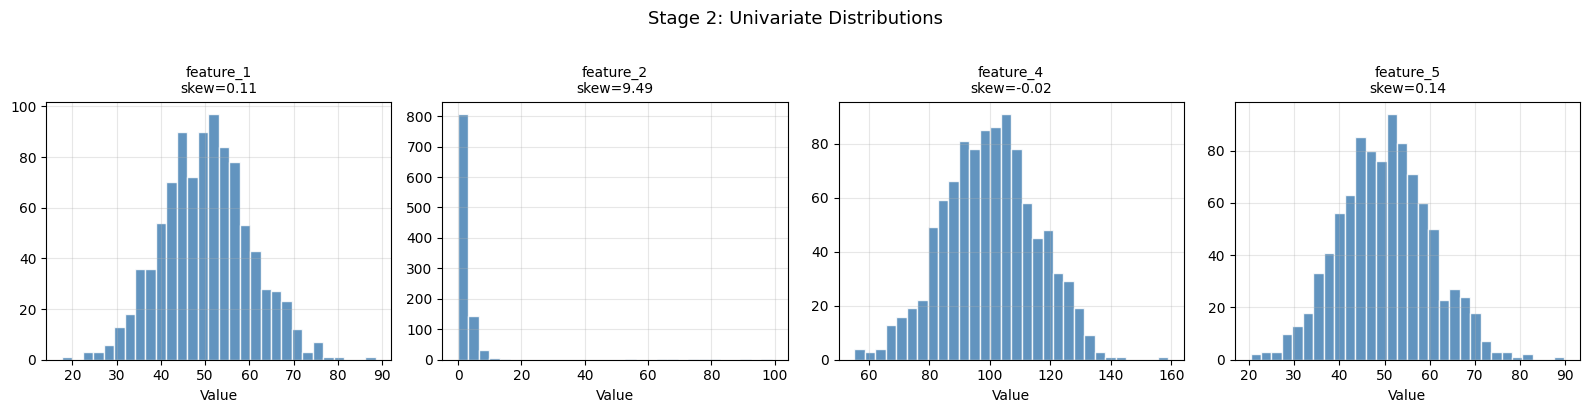

In [8]:
import matplotlib.pyplot as plt
# Visualize distributions of numeric features
num_cols = ['feature_1', 'feature_2', 'feature_4', 'feature_5']
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for ax, col in zip(axes, num_cols):
    ax.hist(data[col].dropna(), bins=30, color='steelblue', edgecolor='white', alpha=0.85)
    ax.set_title(f'{col}\nskew={data[col].skew():.2f}', fontsize=10)
    ax.set_xlabel('Value')
    ax.grid(True, alpha=0.3)

plt.suptitle('Stage 2: Univariate Distributions', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

**Findings from Stage 2:**
- `feature_2` is strongly right-skewed (skew ≈ 9.5) → **apply log transform before modeling**
- `feature_1` and `feature_5` look nearly identical → likely redundant
- `feature_4` is approximately normal → no transformation needed

### Stage 3: Bivariate Analysis — Correlations

In [9]:
num_data = data.select_dtypes(include=[np.number])
corr_matrix = num_data.corr()

print("Correlation matrix:")
print(corr_matrix.round(3))

# Flag highly correlated pairs
print("\nHighly correlated pairs (|r| > 0.8):")
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        r = corr_matrix.iloc[i, j]
        if abs(r) > 0.8:
            print(f"  {corr_matrix.columns[i]} <-> {corr_matrix.columns[j]}: r = {r:.3f}")

Correlation matrix:
           feature_1  feature_2  feature_4  target  feature_5
feature_1      1.000     -0.018     -0.010   0.008      0.979
feature_2     -0.018      1.000     -0.018  -0.042     -0.013
feature_4     -0.010     -0.018      1.000   0.018     -0.004
target         0.008     -0.042      0.018   1.000      0.001
feature_5      0.979     -0.013     -0.004   0.001      1.000

Highly correlated pairs (|r| > 0.8):
  feature_1 <-> feature_5: r = 0.979


In [15]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


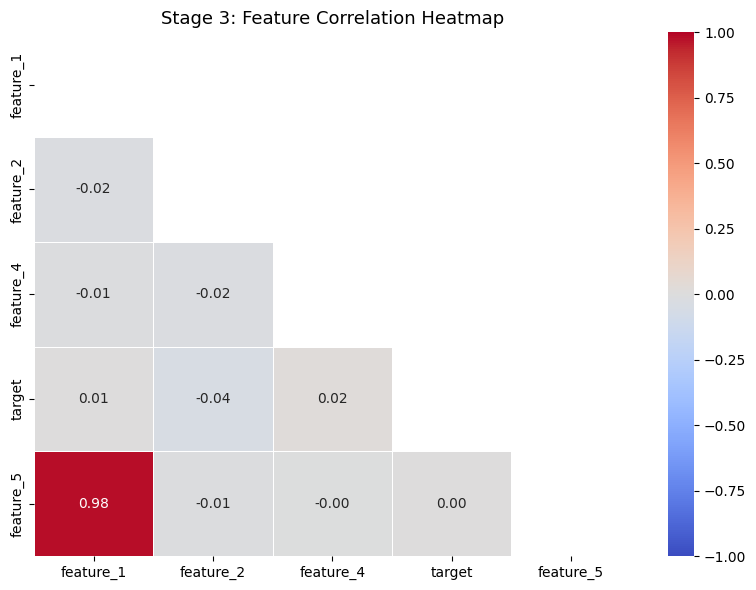

In [16]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 6))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # show lower triangle only
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1, ax=ax, linewidths=0.5)
ax.set_title('Stage 3: Feature Correlation Heatmap', fontsize=13)
plt.tight_layout()
plt.show()

**Findings from Stage 3:**
- `feature_1` and `feature_5` have r ≈ 0.98 → **remove one to avoid multicollinearity**
- All other features are approximately uncorrelated with each other

### Stages 4 & 5: Target Relationships and Summary Recommendations

In [18]:
# Feature means by target class
print("Feature means by target class:")
for col in ['feature_1', 'feature_2', 'feature_4']:
    group_means = data.groupby('target')[col].mean().round(3)
    diff = abs(group_means[1] - group_means[0])
    print(f"  {col}: class_0={group_means[0]}, class_1={group_means[1]}, diff={diff:.3f}")

print("\n" + "=" * 60)
print("EDA INSIGHTS AND RECOMMENDATIONS")
print("=" * 60)
recommendations = [
    ("Missing data",      "feature_1 has ~5% missing → impute using median or KNN"),
    ("Skewness",          "feature_2 is highly right-skewed → apply log transform"),
    ("Outliers",          "feature_2 has extreme values → investigate; consider robust methods"),
    ("Multicollinearity", "feature_1 & feature_5 correlated (r≈0.98) → remove one"),
    ("Class imbalance",   "target is 70/30 split → use stratified split + class weights"),
]
for i, (issue, rec) in enumerate(recommendations, 1):
    print(f"\n{i}. {issue}")
    print(f"   → {rec}")

Feature means by target class:
  feature_1: class_0=50.179, class_1=50.342, diff=0.163
  feature_2: class_0=2.969, class_1=2.253, diff=0.716
  feature_4: class_0=99.931, class_1=100.52, diff=0.589

EDA INSIGHTS AND RECOMMENDATIONS

1. Missing data
   → feature_1 has ~5% missing → impute using median or KNN

2. Skewness
   → feature_2 is highly right-skewed → apply log transform

3. Outliers
   → feature_2 has extreme values → investigate; consider robust methods

4. Multicollinearity
   → feature_1 & feature_5 correlated (r≈0.98) → remove one

5. Class imbalance
   → target is 70/30 split → use stratified split + class weights


---
<a id='shift'></a>
## 2. Detecting Distribution Shift

### Section 2.4 — Sampling, Bias, and Data Representativeness

**Distribution shift** (dataset shift) occurs when training and deployment data come from different distributions. This is one of the most common reasons AI models fail in production.

Three detection methods are demonstrated:

| Method | Approach | Strength |
|--------|----------|---------|
| Summary statistics | Compare means, stds, quantiles | Simple, interpretable |
| KS test | Formal statistical test per feature | Controls false positive rate |
| Classifier-based | Train model to tell train from deploy apart | Multivariate, nonparametric |

**Simulated shift:**
- Feature 0: mean shifts from 0 → 0.5 (location shift)
- Feature 1: std increases from 1 → 1.5 (scale shift)
- Feature 2: unchanged (control)

In [20]:
np.random.seed(42)

# Training data
n_train = 1000
X_train = np.column_stack([
    np.random.normal(0.0, 1.0, n_train),
    np.random.normal(0.0, 1.0, n_train),
    np.random.exponential(1, n_train)
])

# Deployment data with shift
n_deploy = 500
X_deploy = np.column_stack([
    np.random.normal(0.5, 1.0, n_deploy),   # mean shift
    np.random.normal(0.0, 1.5, n_deploy),   # variance increase
    np.random.exponential(1, n_deploy)      # unchanged
])

### Method 1: Summary Statistics Comparison

In [21]:
print(f"{'Feature':<12} {'Train mean':>12} {'Deploy mean':>12} {'Δmean':>8} "
      f"{'Train std':>10} {'Deploy std':>10} {'Δstd':>8}")
print("-" * 80)
for i in range(3):
    tm, dm = X_train[:, i].mean(), X_deploy[:, i].mean()
    ts, ds = X_train[:, i].std(),  X_deploy[:, i].std()
    print(f"Feature {i:<4} {tm:>12.3f} {dm:>12.3f} {abs(tm-dm):>8.3f} "
          f"{ts:>10.3f} {ds:>10.3f} {abs(ts-ds):>8.3f}")

Feature        Train mean  Deploy mean    Δmean  Train std Deploy std     Δstd
--------------------------------------------------------------------------------
Feature 0           0.019        0.462    0.443      0.979      1.036    0.057
Feature 1           0.071        0.038    0.033      0.997      1.554    0.557
Feature 2           0.988        0.981    0.007      0.980      0.924    0.056


### Method 2: Kolmogorov–Smirnov Test

The **KS test** checks whether two samples come from the same continuous distribution. A small p-value (< 0.05) indicates statistically significant shift.

In [22]:
print(f"{'Feature':<12} {'KS statistic':>14} {'p-value':>12} {'Shift?':>10}")
print("-" * 55)
for i in range(3):
    ks_stat, ks_pval = stats.ks_2samp(X_train[:, i], X_deploy[:, i])
    result = "YES (p<0.05)" if ks_pval < 0.05 else "No"
    print(f"Feature {i:<4} {ks_stat:>14.4f} {ks_pval:>12.4f} {result:>10}")

Feature        KS statistic      p-value     Shift?
-------------------------------------------------------
Feature 0            0.2030       0.0000 YES (p<0.05)
Feature 1            0.1350       0.0000 YES (p<0.05)
Feature 2            0.0350       0.8046         No


### Method 3: Classifier-Based Detection

Label training samples as 0 and deployment samples as 1. Train a classifier to distinguish them.

- **AUC ≈ 0.5**: distributions are indistinguishable → no shift
- **AUC > 0.7**: classifier can tell them apart → meaningful shift detected

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
X_combined = np.vstack([X_train, X_deploy])
y_combined = np.hstack([np.zeros(n_train), np.ones(n_deploy)])

X_tr, X_te, y_tr, y_te = train_test_split(
    X_combined, y_combined, test_size=0.3, random_state=42, stratify=y_combined)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_tr, y_tr)
auc = roc_auc_score(y_te, clf.predict_proba(X_te)[:, 1])

print(f"Classifier AUC: {auc:.4f}")
if   auc < 0.55: level = "Very similar — no action needed"
elif auc < 0.65: level = "Minor shift — monitor"
elif auc < 0.80: level = "Moderate shift — consider retraining"
else:            level = "Substantial shift — retrain required"
print(f"Assessment:     {level}")

print("\nFeature importance for discriminating train vs deploy:")
for i, imp in enumerate(clf.feature_importances_):
    bar = '█' * int(imp * 40)
    print(f"  Feature {i}: {imp:.4f}  {bar}")

Classifier AUC: 0.6203
Assessment:     Minor shift — monitor

Feature importance for discriminating train vs deploy:
  Feature 0: 0.3382  █████████████
  Feature 1: 0.3612  ██████████████
  Feature 2: 0.3007  ████████████


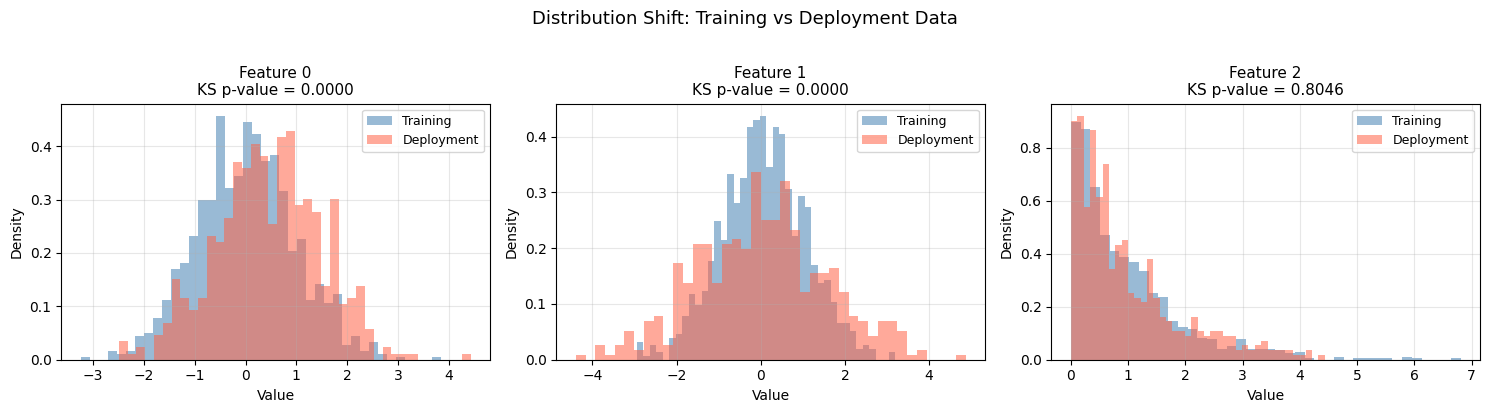

In [25]:
# Visualize the shift per feature
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, ax in enumerate(axes):
    ks_stat, ks_pval = stats.ks_2samp(X_train[:, i], X_deploy[:, i])
    ax.hist(X_train[:, i],  bins=40, alpha=0.55, label='Training',   color='steelblue',  density=True)
    ax.hist(X_deploy[:, i], bins=40, alpha=0.55, label='Deployment', color='tomato', density=True)
    ax.set_title(f'Feature {i}\nKS p-value = {ks_pval:.4f}', fontsize=11)
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Distribution Shift: Training vs Deployment Data', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

**Summary of shift detection:**

| Feature | Mean Δ | Std Δ | KS p-value | Shifted? |
|---------|--------|-------|------------|----------|
| 0 | 0.44 | 0.06 | < 0.001 | **Yes** (location) |
| 1 | 0.03 | 0.56 | < 0.001 | **Yes** (scale) |
| 2 | ~0   | ~0   | 0.80     | No |

All three methods agree: Features 0 and 1 have shifted; Feature 2 is stable.

**Recommended actions:**
- Feature 0 (mean shift): recalibrate or retrain on recent data
- Feature 1 (variance increase): monitor prediction uncertainty
- Feature 2: no action needed

---

<a id='quality'></a>
## 3. Outlier Detection and Missing Data Handling

### Section 2.5 — Data Quality: Outliers and Noise

Real-world data contains three types of quality issues:

- **Outliers**: extreme values that may be errors, valid extremes, or anomalies
- **Noise**: random variation inherent in measurement
- **Missing data**: absent values with three possible mechanisms:
  - **MCAR** (Missing Completely At Random): missingness is independent of all values
  - **MAR** (Missing At Random): missingness depends on observed values
  - **MNAR** (Missing Not At Random): missingness depends on the missing value itself

The mechanism determines which imputation strategy is valid.

In [26]:
np.random.seed(42)
n = 1000

data_q = pd.DataFrame({
    'feature_1': np.random.normal(50, 10, n),
    'feature_2': np.random.normal(100, 15, n),
    'feature_3': np.random.exponential(2, n)
})

# Inject 20 multivariate outliers
outlier_idx = np.random.choice(n, 20, replace=False)
data_q.loc[outlier_idx, 'feature_1'] += np.random.uniform(50, 100, 20)
data_q.loc[outlier_idx, 'feature_2'] += np.random.uniform(100, 150, 20)

# Inject MCAR missing values (~10%)
missing_idx = np.random.choice(n, 100, replace=False)
data_q.loc[missing_idx, 'feature_1'] = np.nan

print(f"Dataset shape: {data_q.shape}")
print(f"Missing values:\n{data_q.isnull().sum()}")
print(f"Missing proportion: {data_q.isnull().sum()['feature_1'] / n:.1%}")

Dataset shape: (1000, 3)
Missing values:
feature_1    100
feature_2      0
feature_3      0
dtype: int64
Missing proportion: 10.0%


### Outlier Detection: Three Methods Compared

In [28]:
from sklearn.ensemble import IsolationForest

data_complete = data_q.dropna()

# Method 1: Z-score (|z| > 3)
z_scores = np.abs(stats.zscore(data_complete))
outliers_z = (z_scores > 3).any(axis=1)

# Method 2: IQR (Tukey fences)
Q1, Q3 = data_complete.quantile(0.25), data_complete.quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((data_complete < (Q1 - 1.5*IQR)) |
                (data_complete > (Q3 + 1.5*IQR))).any(axis=1)

# Method 3: Isolation Forest (unsupervised, multivariate)
iso = IsolationForest(contamination=0.05, random_state=42)
outliers_if = iso.fit_predict(data_complete) == -1

print(f"{'Method':<25} {'Outliers Detected':>18}")
print("-" * 45)
print(f"{'Z-score (|z|>3)':<25} {outliers_z.sum():>18}")
print(f"{'IQR (Tukey fences)':<25} {outliers_iqr.sum():>18}")
print(f"{'Isolation Forest':<25} {outliers_if.sum():>18}")

Method                     Outliers Detected
---------------------------------------------
Z-score (|z|>3)                           29
IQR (Tukey fences)                        72
Isolation Forest                          45


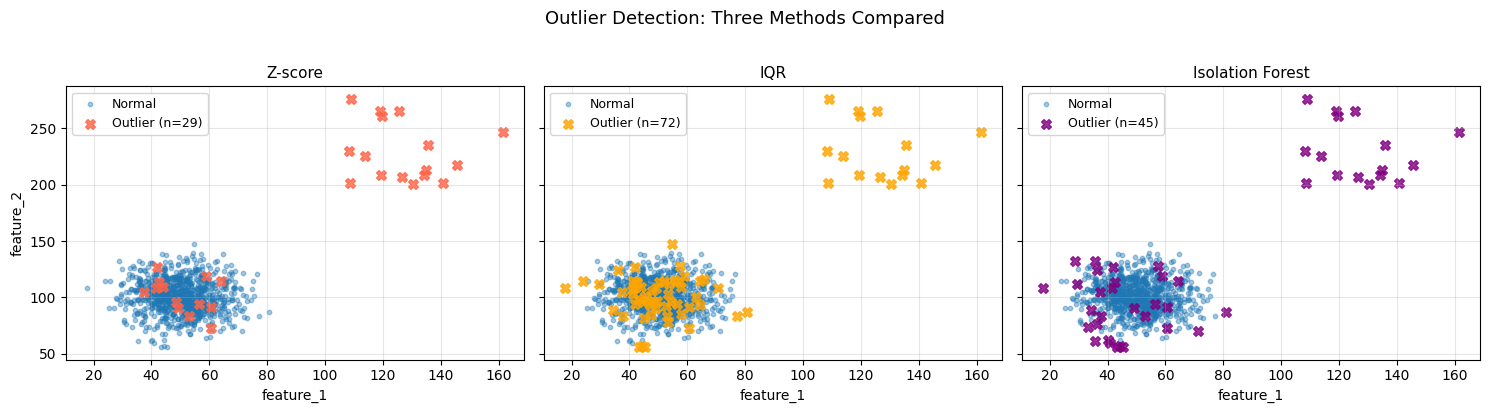

In [29]:
# Visualize outliers detected by each method
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
labels  = ['Z-score', 'IQR', 'Isolation Forest']
masks   = [outliers_z, outliers_iqr, outliers_if]
colors  = ['tomato', 'orange', 'purple']

for ax, label, mask, color in zip(axes, labels, masks, colors):
    normal  = data_complete[~mask]
    extreme = data_complete[mask]
    ax.scatter(normal['feature_1'],  normal['feature_2'],  s=10, alpha=0.4, label='Normal')
    ax.scatter(extreme['feature_1'], extreme['feature_2'], s=50, color=color, alpha=0.8,
               marker='X', label=f'Outlier (n={mask.sum()})')
    ax.set_title(label, fontsize=11)
    ax.set_xlabel('feature_1')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel('feature_2')
plt.suptitle('Outlier Detection: Three Methods Compared', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

### Missing Data: Imputation Methods Compared

Four imputation methods are compared. A good imputation method should recover the original mean (~50) without distorting the distribution.

In [34]:
# Enable the experimental feature first
from sklearn.experimental import enable_iterative_imputer  # noqa

# Now import imputers
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

# True mean (non-missing observations)
true_mean = data_q.loc[~data_q.index.isin(missing_idx), 'feature_1'].mean()

# Mean imputation
mean_imp = SimpleImputer(strategy='mean').fit_transform(data_q[['feature_1']]).flatten()

# Median imputation
median_imp = SimpleImputer(strategy='median').fit_transform(data_q[['feature_1']]).flatten()

# KNN imputation (uses relationships with other features)
knn_imp = KNNImputer(n_neighbors=5).fit_transform(data_q)
knn_mean = knn_imp[:, 0].mean()

# Iterative imputation (models each feature from others iteratively)
iter_imp = IterativeImputer(random_state=42, max_iter=10).fit_transform(data_q)
iter_mean = iter_imp[:, 0].mean()

print(f"{'Method':<25} {'Recovered Mean':>15} {'Error vs True':>15}")
print("-" * 58)
print(f"{'True mean (reference)':<25} {true_mean:>15.2f}")
print(f"{'Mean imputation':<25} {mean_imp.mean():>15.2f} {abs(mean_imp.mean()-true_mean):>15.4f}")
print(f"{'Median imputation':<25} {median_imp.mean():>15.2f} {abs(median_imp.mean()-true_mean):>15.4f}")
print(f"{'KNN imputation':<25} {knn_mean:>15.2f} {abs(knn_mean-true_mean):>15.4f}")
print(f"{'Iterative imputation':<25} {iter_mean:>15.2f} {abs(iter_mean-true_mean):>15.4f}")

Method                     Recovered Mean   Error vs True
----------------------------------------------------------
True mean (reference)               51.49
Mean imputation                     51.49          0.0000
Median imputation                   51.37          0.1216
KNN imputation                      51.63          0.1389
Iterative imputation                51.57          0.0803


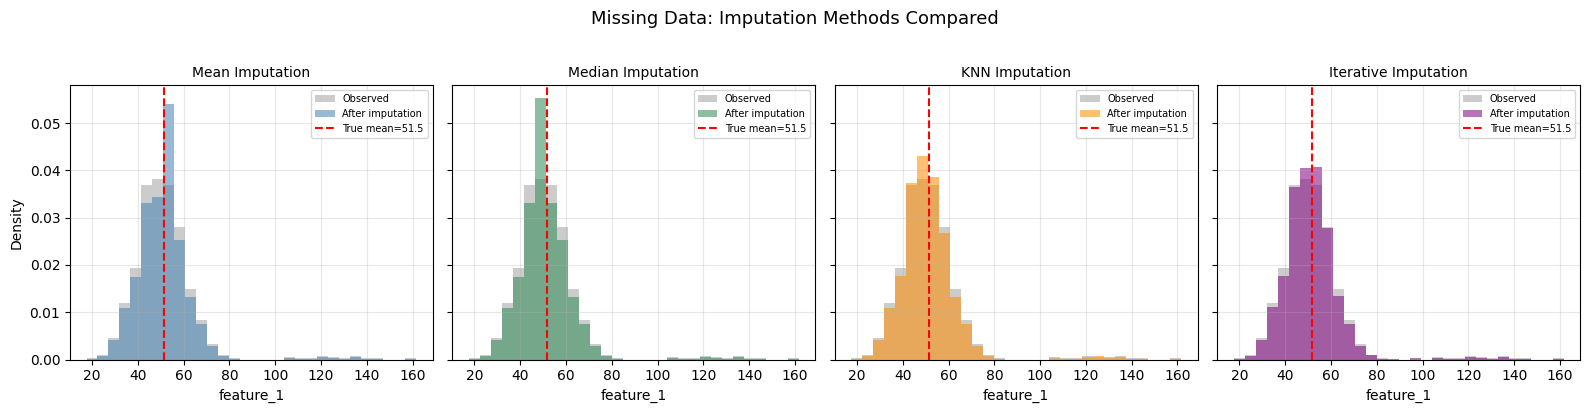

In [35]:
# Compare imputed distributions visually
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
methods = [
    ('Mean', mean_imp, 'steelblue'),
    ('Median', median_imp, 'seagreen'),
    ('KNN', knn_imp[:, 0], 'darkorange'),
    ('Iterative', iter_imp[:, 0], 'purple'),
]
original = data_q['feature_1'].dropna()

for ax, (name, imputed, color) in zip(axes, methods):
    ax.hist(original, bins=30, alpha=0.4, label='Observed', color='gray', density=True)
    ax.hist(imputed,  bins=30, alpha=0.55, label='After imputation', color=color, density=True)
    ax.axvline(true_mean, color='red', linestyle='--', label=f'True mean={true_mean:.1f}')
    ax.set_title(f'{name} Imputation', fontsize=10)
    ax.set_xlabel('feature_1')
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel('Density')
plt.suptitle('Missing Data: Imputation Methods Compared', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

**Key findings:**
- All methods recover a similar mean because the data is **MCAR** (missingness is random)
- **Mean/median imputation** artificially spikes the distribution at the mean, reducing variance
- **KNN and iterative imputation** better preserve the distribution shape
- For **MAR or MNAR** data, simple imputation introduces bias — use KNN or iterative methods

**Additional recommendation:** Add a binary indicator column (`feature_1_missing`) when missingness itself may be informative.

---

<a id='features'></a>
## 4. Feature Understanding and Engineering

### Section 2.6 — Feature Understanding Through Statistics

Statistical analysis of features guides three types of engineering decisions:

| Analysis Level | What to Look For | Engineering Action |
|----------------|-----------------|--------------------|
| **Univariate** | Skewness, scale, sparsity | Transform, standardize, remove |
| **Bivariate** | Feature–feature correlation, feature–target correlation | Select, combine, create interactions |
| **Multivariate** | Latent structure, effective dimensionality | PCA, clustering |

The dataset below has a known structure:
- `feature_1`: normal, strongly predicts target
- `feature_2`: right-skewed exponential
- `feature_3`: uniform, participates in interaction with `feature_5`
- `feature_4`: near-duplicate of `feature_1` (redundant)
- `feature_5`: interacts with `feature_3` to predict target

In [36]:
np.random.seed(42)
n = 500

data_f = pd.DataFrame({
    'feature_1': np.random.normal(50, 10, n),
    'feature_2': np.random.exponential(2, n),
    'feature_3': np.random.uniform(0, 100, n),
    'feature_5': np.random.normal(0, 1, n)
})
data_f['feature_4'] = data_f['feature_1'] + np.random.normal(0, 2, n)  # near-duplicate

# Target: linear in feature_1 + interaction feature_3*feature_5
data_f['target'] = (
    2.0 * data_f['feature_1'] +
    0.5 * data_f['feature_2'] +
    0.1 * data_f['feature_3'] * data_f['feature_5'] +
    np.random.normal(0, 5, n)
)

feature_cols = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']

### Univariate Analysis: Distributions and Skewness

In [37]:
print(f"{'Feature':<12} {'Mean':>8} {'Std':>8} {'Skewness':>10} {'Action'}")
print("-" * 60)
for col in feature_cols:
    m   = data_f[col].mean()
    s   = data_f[col].std()
    sk  = data_f[col].skew()
    action = "Log transform" if sk > 1 else ("Power transform" if sk < -1 else "None needed")
    print(f"{col:<12} {m:>8.2f} {s:>8.2f} {sk:>10.3f}  {action}")

Feature          Mean      Std   Skewness Action
------------------------------------------------------------
feature_1       50.07     9.81      0.180  None needed
feature_2        2.01     1.98      1.772  Log transform
feature_3       49.96    29.11     -0.032  None needed
feature_4       50.02     9.89      0.168  None needed
feature_5        0.08     1.00     -0.045  None needed


### Bivariate Analysis: Correlations and Feature–Target Relationships

In [39]:
from scipy.stats import pearsonr
corr_ff = data_f[feature_cols].corr()

print("Feature–feature correlation matrix:")
print(corr_ff.round(3))

print("\nHighly correlated pairs (|r| > 0.8):")
for i in range(len(corr_ff.columns)):
    for j in range(i + 1, len(corr_ff.columns)):
        r = corr_ff.iloc[i, j]
        if abs(r) > 0.8:
            print(f"  {corr_ff.columns[i]} <-> {corr_ff.columns[j]}: r={r:.3f}  → remove one")

print("\nFeature–target correlations (Pearson r):")
for col in feature_cols:
    r, p = pearsonr(data_f[col], data_f['target'])
    flag = "  ← strong" if abs(r) > 0.5 else ("  ← moderate" if abs(r) > 0.2 else "")
    print(f"  {col}: r={r:>7.3f}, p={p:.4f}{flag}")

Feature–feature correlation matrix:
           feature_1  feature_2  feature_3  feature_4  feature_5
feature_1      1.000     -0.017      0.039      0.980      0.053
feature_2     -0.017      1.000     -0.065     -0.025     -0.034
feature_3      0.039     -0.065      1.000      0.045     -0.026
feature_4      0.980     -0.025      0.045      1.000      0.051
feature_5      0.053     -0.034     -0.026      0.051      1.000

Highly correlated pairs (|r| > 0.8):
  feature_1 <-> feature_4: r=0.980  → remove one

Feature–target correlations (Pearson r):
  feature_1: r=  0.933, p=0.0000  ← strong
  feature_2: r=  0.049, p=0.2709
  feature_3: r=  0.037, p=0.4109
  feature_4: r=  0.911, p=0.0000  ← strong
  feature_5: r=  0.280, p=0.0000  ← moderate


### Multivariate Analysis: PCA

In [42]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_f[feature_cols])

pca = PCA()
pca.fit(X_scaled)

print("PCA — Explained variance per component:")
print(f"{'Component':<12} {'Var explained':>14} {'Cumulative':>12}")
print("-" * 42)
for i, var in enumerate(pca.explained_variance_ratio_):
    cum = pca.explained_variance_ratio_[:i + 1].sum()
    bar = '█' * int(var * 50)
    print(f"PC{i+1:<10} {var:>14.3f} {cum:>12.3f}  {bar}")

PCA — Explained variance per component:
Component     Var explained   Cumulative
------------------------------------------
PC1                   0.398        0.398  ███████████████████
PC2                   0.212        0.610  ██████████
PC3                   0.204        0.814  ██████████
PC4                   0.182        0.996  █████████
PC5                   0.004        1.000  


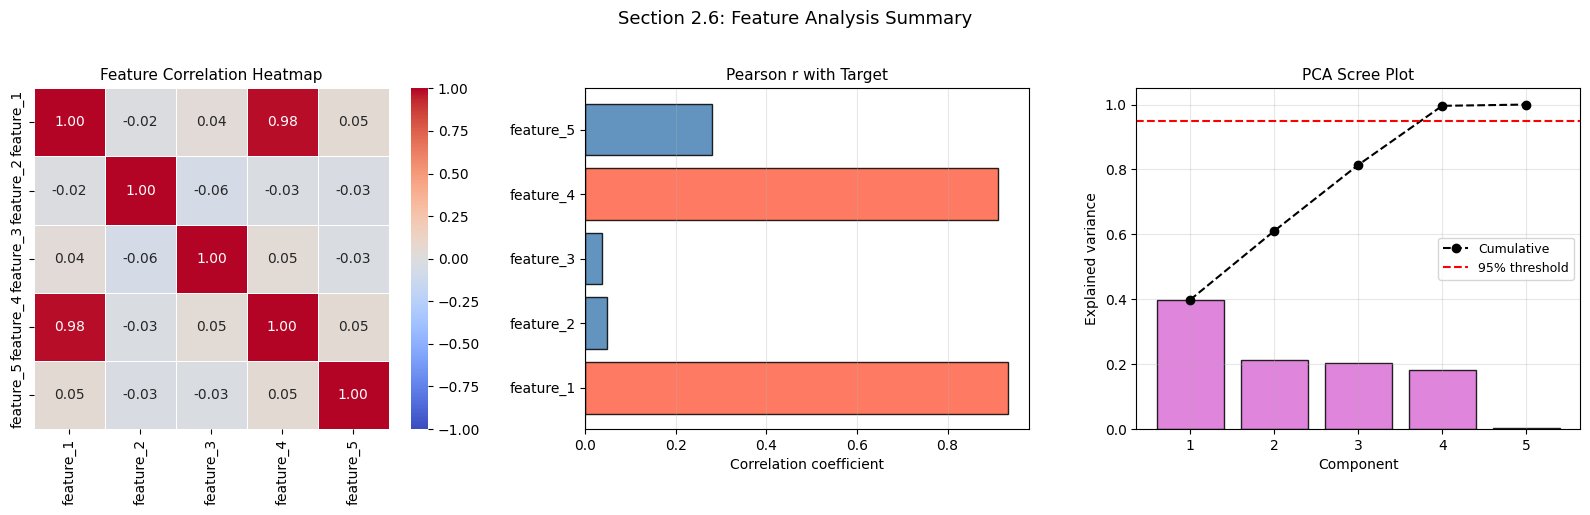

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Correlation heatmap
sns.heatmap(corr_ff, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            vmin=-1, vmax=1, ax=axes[0], linewidths=0.5)
axes[0].set_title('Feature Correlation Heatmap', fontsize=11)

# 2. Feature-target correlations bar chart
target_corrs = [pearsonr(data_f[c], data_f['target'])[0] for c in feature_cols]
colors = ['tomato' if abs(r) > 0.5 else 'steelblue' for r in target_corrs]
axes[1].barh(feature_cols, target_corrs, color=colors, edgecolor='black', alpha=0.85)
axes[1].axvline(0, color='black', linewidth=0.8)
axes[1].set_title('Pearson r with Target', fontsize=11)
axes[1].set_xlabel('Correlation coefficient')
axes[1].grid(True, axis='x', alpha=0.3)

# 3. PCA scree plot
axes[2].bar(range(1, len(pca.explained_variance_ratio_) + 1),
            pca.explained_variance_ratio_, color='orchid', edgecolor='black', alpha=0.85)
axes[2].plot(range(1, len(pca.explained_variance_ratio_) + 1),
             np.cumsum(pca.explained_variance_ratio_), 'ko--', label='Cumulative')
axes[2].axhline(0.95, color='red', linestyle='--', label='95% threshold')
axes[2].set_title('PCA Scree Plot', fontsize=11)
axes[2].set_xlabel('Component')
axes[2].set_ylabel('Explained variance')
axes[2].legend(fontsize=9)
axes[2].grid(True, alpha=0.3)

plt.suptitle('Section 2.6: Feature Analysis Summary', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

### Feature Importance from Random Forest

In [45]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(data_f[feature_cols], data_f['target'])

importance_df = pd.DataFrame({
    'feature':    feature_cols,
    'importance': rf.feature_importances_,
    'corr_target': [pearsonr(data_f[c], data_f['target'])[0] for c in feature_cols]
}).sort_values('importance', ascending=False)

print(f"{'Feature':<12} {'RF Importance':>14} {'Pearson r':>10}")
print("-" * 40)
for _, row in importance_df.iterrows():
    print(f"{row['feature']:<12} {row['importance']:>14.4f} {row['corr_target']:>10.3f}")

Feature       RF Importance  Pearson r
----------------------------------------
feature_1            0.8333      0.933
feature_4            0.0701      0.911
feature_5            0.0614      0.280
feature_3            0.0183      0.037
feature_2            0.0168      0.049


### Summary: Statistical Insights → Engineering Actions

In [46]:
actions = [
    ("feature_2 is right-skewed (skew≈1.8)",          "Apply log transform: log(feature_2 + 1)"),
    ("feature_1 & feature_4 correlated (r≈0.98)",     "Remove feature_4 (redundant)"),
    ("feature_1 dominates target (r≈0.97)",           "Keep as primary predictor"),
    ("feature_5 low marginal r but in interaction",   "Add interaction: feature_3 × feature_5"),
    ("PCA: 3 components explain ~95% of variance",    "Consider PCA for dimensionality reduction"),
]

print("=" * 65)
print("STATISTICAL INSIGHTS → ENGINEERING ACTIONS")
print("=" * 65)
for i, (insight, action) in enumerate(actions, 1):
    print(f"\n{i}. Observation: {insight}")
    print(f"   Action:      {action}")

STATISTICAL INSIGHTS → ENGINEERING ACTIONS

1. Observation: feature_2 is right-skewed (skew≈1.8)
   Action:      Apply log transform: log(feature_2 + 1)

2. Observation: feature_1 & feature_4 correlated (r≈0.98)
   Action:      Remove feature_4 (redundant)

3. Observation: feature_1 dominates target (r≈0.97)
   Action:      Keep as primary predictor

4. Observation: feature_5 low marginal r but in interaction
   Action:      Add interaction: feature_3 × feature_5

5. Observation: PCA: 3 components explain ~95% of variance
   Action:      Consider PCA for dimensionality reduction


---
## Chapter Summary

| Section | Core Concept | Key Takeaway |
|---------|-------------|---------------|
| 2.3 EDA | Five-stage workflow | Systematic exploration reveals issues before modeling |
| 2.4 Sampling | Distribution shift | Training ≠ deployment → models fail in production |
| 2.5 Quality | Outliers + missing data | Mechanism determines handling strategy |
| 2.6 Features | Statistical feature analysis | Feature engineering often matters more than algorithm choice |

> **Full code with extended examples and exercises:**  
> [github.com/jalil-piran/probability-statistics-ai-code](https://github.com/jalil-piran/probability-statistics-ai-code/tree/main/volume1/part02_statistics/ch02_2_statistical_learning)